## Stock Price Prediction using LSTM and XGBoost with Feature Engineering & Hyperparameter Tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.base import BaseEstimator, RegressorMixin
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download historical stock data
ticker = "GOOGL"
start_date = "2018-01-01"
end_date = "2023-10-31"

df = yf.download(ticker, start=start_date, end=end_date, progress=False)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000
...,...,...,...,...,...,...
2023-10-24,137.830002,139.360001,137.419998,138.809998,138.809998,44814300
2023-10-25,128.160004,128.309998,125.070000,125.610001,125.610001,84366200
2023-10-26,123.269997,124.330002,121.269997,122.279999,122.279999,57061100


In [3]:
# Check for null values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
# Remove duplicate rows
df = df.loc[~df.index.duplicated(keep='first')]
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000
...,...,...,...,...,...,...
2023-10-24,137.830002,139.360001,137.419998,138.809998,138.809998,44814300
2023-10-25,128.160004,128.309998,125.070000,125.610001,125.610001,84366200
2023-10-26,123.269997,124.330002,121.269997,122.279999,122.279999,57061100


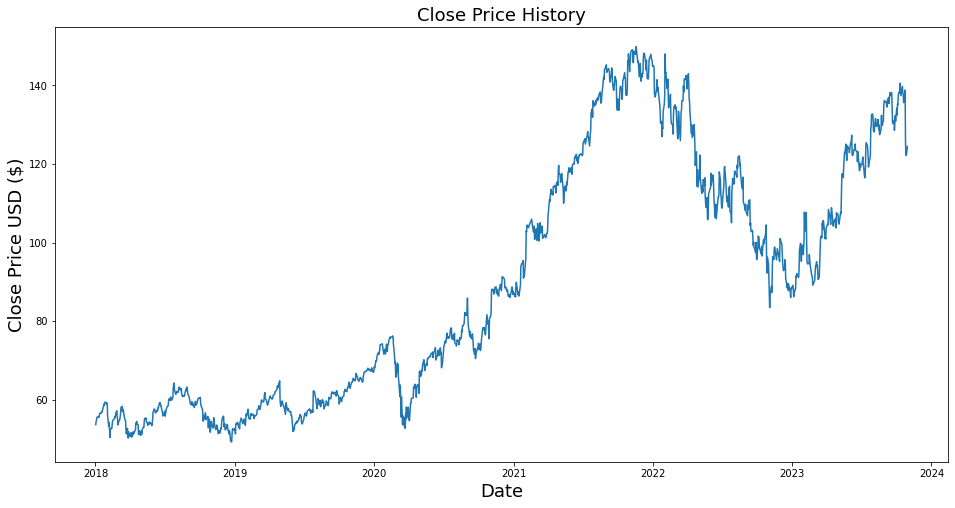

In [5]:
# Plot the closing price
plt.figure(figsize=(16,8))
plt.title('Close Price History', fontsize=18)
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [6]:
# Feature Engineering
df['Return'] = df['Close'].pct_change() # Simple daily return
df['Moving_Avg_5'] = df['Close'].rolling(window=5).mean() # 5-day moving average
df['Moving_Avg_10'] = df['Close'].rolling(window=10).mean() # 10-day moving average
df['Moving_STD_10'] = df['Close'].rolling(window=10).std() # 10-day moving standard deviation

# Replace NA values with 0
df.fillna(0, inplace=True)

df.head(30)

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000,0.000000,0.000000,0.000000,0.000000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000,0.017061,0.000000,0.000000,0.000000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000,0.003884,0.000000,0.000000,0.000000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000,0.013260,0.000000,0.000000,0.000000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000,0.003531,54.849899,0.000000,0.000000
2018-01-09,55.922001,55.922001,55.410000,55.639500,55.639500,26808000,-0.001274,55.245699,0.000000,0.000000
2018-01-10,55.349998,55.639000,55.199001,55.507000,55.507000,20734000,-0.002381,55.431899,0.000000,0.000000
2018-01-11,55.615501,55.742500,55.324001,55.602501,55.602501,22424000,0.001721,55.594800,0.000000,0.000000
2018-01-12,55.505001,56.564999,55.400501,56.532501,56.532501,38586000,0.016726,55.798400,0.000000,0.000000


In [7]:
# Removing first 9 rows since they contain 0 values
df1 = df[9:]

df1.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-16,57.015499,57.444000,56.3330,56.535000,56.535000,36462000,0.000044,55.963300,55.40660,0.873630
2018-01-17,56.818001,56.966000,56.1745,56.955002,56.955002,27830000,0.007429,56.226401,55.73605,0.755158
2018-01-18,56.967499,57.029499,56.2230,56.798500,56.798500,27498000,-0.002748,56.484701,55.95830,0.700913
2018-01-19,56.901501,57.188999,56.6250,57.174999,57.174999,30552000,0.006629,56.799200,56.19700,0.663533
2018-01-22,57.191002,58.344002,57.0910,58.208000,58.208000,29550000,0.018067,57.134300,56.46635,0.870204


In [8]:
# Define the features and the target variable
features = ['Open', 'High', 'Low', 'Return', 'Moving_Avg_5', 'Moving_Avg_10', 'Moving_STD_10']

X = df1[features]
y = df1['Close']

# Feature Scaling
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1,1))

In [9]:
# Split the data into training and testing sets using 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42)

In [10]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1166, 7)
y_train shape:  (1166, 1)
X_test shape:  (292, 7)
y_test shape:  (292, 1)


In [11]:
# Since LSTM expects a 3D array as input, we need to reshape the data
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [12]:
print("X_train_lstm shape: ", X_train_lstm.shape)
print("X_test_lstm shape: ", X_test_lstm.shape)

X_train_lstm shape:  (1166, 1, 7)
X_test_lstm shape:  (292, 1, 7)


In [13]:
# Create a Estimator class for LSTM model
class LSTMEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, optimizer='adam'):
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add(LSTM(100, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1))
        self.model.compile(optimizer=self.optimizer, loss='mse')

    def fit(self, X, y):
        self.model.fit(X, y, epochs=100, batch_size=64, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()
    
# Create the LSTM model
lstm_model = LSTMEstimator()
lstm_model.fit(X_train_lstm, y_train)

LSTMEstimator()

In [14]:
# Create XGBRegressor model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [15]:
# Make predictions
lstm_pred = lstm_model.predict(X_test_lstm)
xgb_pred = xgb_model.predict(X_test)

10/10 [==============================] - 0s 2ms/step


In [16]:
# Create a stacked model
stacked_pred = np.column_stack((lstm_pred, xgb_pred))

# Train final regressor based on stacked predictions
final_regressor = LinearRegression().fit(stacked_pred, y_test)

final_pred = final_regressor.predict(stacked_pred)

In [17]:
# Inverse transform the predicted values to the original scale
lstm_pred_inv = target_scaler.inverse_transform(lstm_pred.reshape(-1, 1))
xgb_pred_inv = target_scaler.inverse_transform(xgb_pred.reshape(-1, 1))
final_pred_inv = target_scaler.inverse_transform(final_pred.reshape(-1, 1))
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

In [18]:
# Calculate Evaluation Metrics for LSTM model
lstm_mse = mean_squared_error(y_test_inv, lstm_pred_inv)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_inv, lstm_pred_inv)
lstm_r2 = r2_score(y_test_inv, lstm_pred_inv)

print("LSTM Model Evaluation Metrics")
print("-----------------------------")
print("MSE: {:.4f}".format(lstm_mse))
print("RMSE: {:.4f}".format(lstm_rmse))
print("MAE: {:.4f}".format(lstm_mae))
print("R2 Score: {:.4f}".format(lstm_r2))

LSTM Model Evaluation Metrics
-----------------------------
MSE: 1.3683
RMSE: 1.1697
MAE: 0.9170
R2 Score: 0.9948


In [19]:
# Calculate Evaluation Metrics for XGBRegressor model
xgb_mse = mean_squared_error(y_test_inv, xgb_pred_inv)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test_inv, xgb_pred_inv)
xgb_r2 = r2_score(y_test_inv, xgb_pred_inv)

print("XGBRegressor Model Evaluation Metrics")
print("-------------------------------------")
print("MSE: {:.4f}".format(xgb_mse))
print("RMSE: {:.4f}".format(xgb_rmse))
print("MAE: {:.4f}".format(xgb_mae))
print("R2 Score: {:.4f}".format(xgb_r2))

XGBRegressor Model Evaluation Metrics
-------------------------------------
MSE: 1.8261
RMSE: 1.3513
MAE: 0.9734
R2 Score: 0.9930


In [20]:
# Calculate Evaluation Metrics for Stacked model
final_mse = mean_squared_error(y_test_inv, final_pred_inv)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test_inv, final_pred_inv)
final_r2 = r2_score(y_test_inv, final_pred_inv)

print("LSTM-XGBoost Stacked Model Evaluation Metrics")
print("---------------------------------------------")
print("MSE: {:.4f}".format(final_mse))
print("RMSE: {:.4f}".format(final_rmse))
print("MAE: {:.4f}".format(final_mae))
print("R2 Score: {:.4f}".format(final_r2))

LSTM-XGBoost Stacked Model Evaluation Metrics
---------------------------------------------
MSE: 0.7882
RMSE: 0.8878
MAE: 0.6887
R2 Score: 0.9970


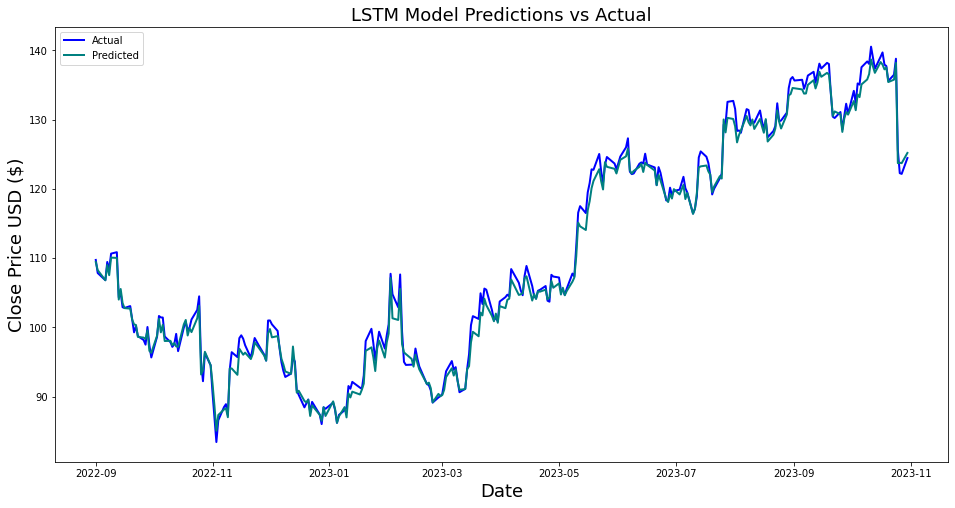

In [21]:
# Plot the actual values vs the predicted values for LSTM model
plt.figure(figsize=(16,8))
plt.title('LSTM Model Predictions vs Actual', fontsize=18)
plt.plot(df1[-len(y_test_inv):].index, y_test_inv, linewidth=2, color='blue', label='Actual')
plt.plot(df1[-len(y_test_inv):].index, lstm_pred_inv, linewidth=2, color='teal', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()

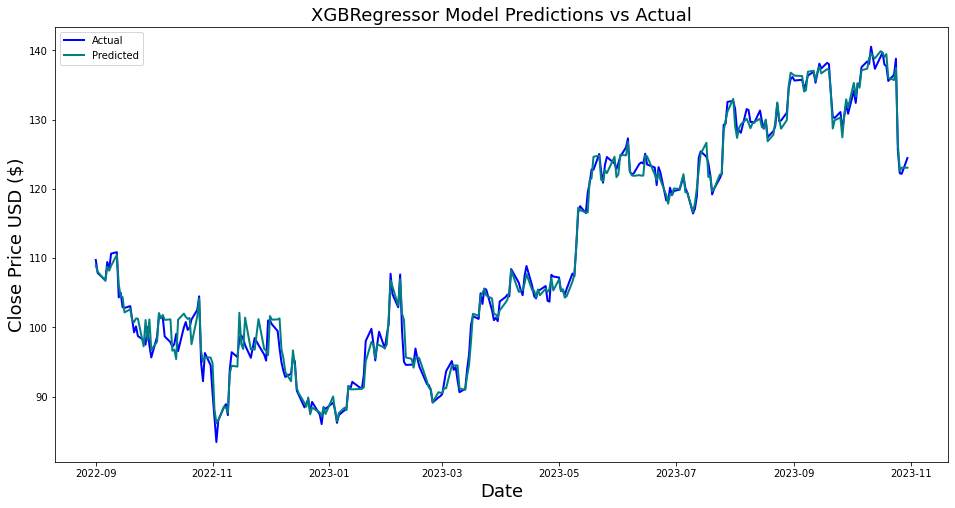

In [22]:
# Plot the actual values vs the predicted values for XGBRegressor model
plt.figure(figsize=(16,8))
plt.title('XGBRegressor Model Predictions vs Actual', fontsize=18)
plt.plot(df1[-len(y_test_inv):].index, y_test_inv, linewidth=2, color='blue', label='Actual')
plt.plot(df1[-len(y_test_inv):].index, xgb_pred_inv, linewidth=2, color='teal', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()

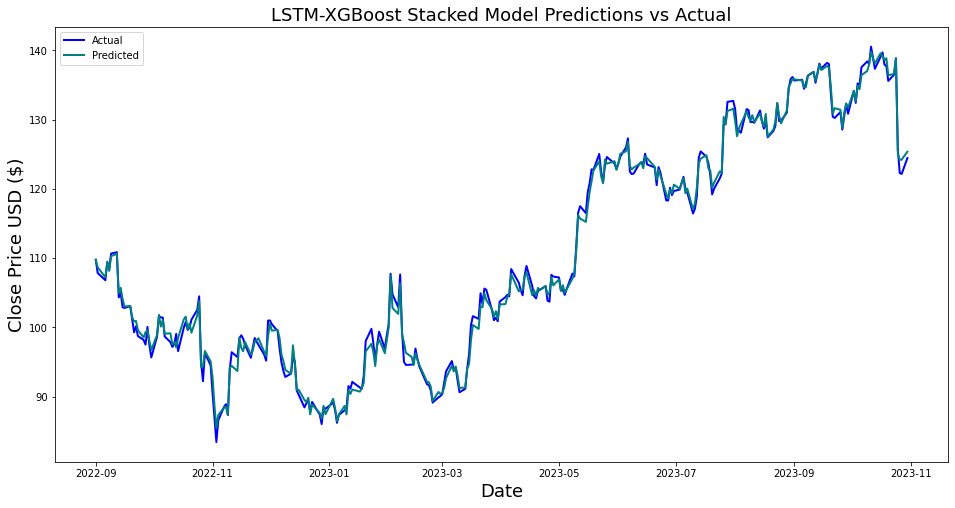

In [23]:
# Plot the actual values vs the predicted values for Stacked model
plt.figure(figsize=(16,8))
plt.title('LSTM-XGBoost Stacked Model Predictions vs Actual', fontsize=18)
plt.plot(df1[-len(y_test_inv):].index, y_test_inv, linewidth=2, color='blue', label='Actual')
plt.plot(df1[-len(y_test_inv):].index, final_pred_inv, linewidth=2, color='teal', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()

In [24]:
# Build a dataframe with actual and predicted prices
df_pred = pd.DataFrame({'Date': df1.index[-len(y_test):], 'Actual': y_test_inv.flatten(),'LSTM': lstm_pred_inv.flatten(), 'XGBoost': xgb_pred_inv.flatten(), 'LSTM-XGBoost': final_pred_inv.flatten()})
df_pred

,Date,Actual,LSTM,XGBoost,LSTM-XGBoost
0,2022-09-01,109.739998,109.427101,108.933716,109.789047
1,2022-09-02,107.849998,108.266678,108.027969,108.674873
2,2022-09-06,106.809998,106.802048,106.718987,107.228081
3,2022-09-07,109.449997,109.015762,108.748367,109.427292
4,2022-09-08,108.379997,107.534035,108.196457,108.152443
...,...,...,...,...,...
287,2023-10-24,138.809998,138.221542,137.510605,138.928024
288,2023-10-25,125.610001,123.720276,126.510628,125.082527
289,2023-10-26,122.279999,123.780045,122.611649,124.175217
290,2023-10-27,122.169998,123.718811,123.061218,124.238014


In [25]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_lstm = []

# Predicting stock prices for the next 2 days
for _ in range(2):
    # Prepare the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predicting the next day stock price using the last feature data
    predicted_price = lstm_model.predict(last_features_lstm)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_lstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (LSTM Model):")
for i, price in enumerate(predicted_prices_lstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 39ms/step
Predicted Closing Prices for the Next 2 Days (LSTM Model):
Day 1:125.201
Day 2:122.006


In [26]:
last_features = X_scaled[-1:]

# Predict using the XGB model
predicted_prices_xgb = []

last_features_xgb = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_xgb = xgb_model.predict(last_features_xgb)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_xgb = predicted_price_xgb.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_xgb = target_scaler.inverse_transform(predicted_price_reshaped_xgb)[0][0]
    predicted_prices_xgb.append(inverse_transformed_price_xgb)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_xgb = np.array([
        last_features_xgb[0, 1], 
        last_features_xgb[0, 2], 
        predicted_price_reshaped_xgb[0, 0], 
        (predicted_price_reshaped_xgb[0, 0] - last_features_xgb[0, 3]) / last_features_xgb[0, 3],
        np.mean(np.append(last_features_xgb[0, 4:6], predicted_price_reshaped_xgb[0, 0])),
        np.mean(np.append(last_features_xgb[0, 5:], predicted_price_reshaped_xgb[0, 0])),
        np.std(np.append(last_features_xgb[0, 6:], predicted_price_reshaped_xgb[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_xgb = new_features_xgb

print("\nPredicted Closing Prices for the Next 2 Days (XGB Model):")
for i, price in enumerate(predicted_prices_xgb):
    print(f"Day {i+1}:" "{:.3f}".format(price))


Predicted Closing Prices for the Next 2 Days (XGB Model):
Day 1:123.066
Day 2:119.455


In [27]:
last_features = X_scaled[-1:]

# Predict using the Stacked LSTM-XGB model
predicted_prices_stacked = []

for day in range(2):
    # Reshape the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predict using LSTM & XGB models
    lstm_pred_for_stacking = lstm_model.predict(last_features_lstm).flatten()
    xgb_pred_for_stacking = xgb_model.predict(last_features).flatten()

    # Stacking LSTM and xgb predictions
    stacked_predictions = np.column_stack((lstm_pred_for_stacking, xgb_pred_for_stacking))
    
    # Predict using the final regressor
    predicted_stacked = final_regressor.predict(stacked_predictions)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_stacked = predicted_stacked.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_stacked = target_scaler.inverse_transform(predicted_price_reshaped_stacked)[0][0]
    predicted_prices_stacked.append(inverse_transformed_price_stacked)

    # For the next prediction, update the features with the newly predicted price.
    # We reuse the logic from LSTM to compute new features for simplicity.
    new_features_stacked = np.array([
        last_features[0, 1], 
        last_features[0, 2], 
        predicted_price_reshaped_stacked[0, 0], 
        (predicted_price_reshaped_stacked[0, 0] - last_features[0, 3]) / last_features[0, 3],
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped_stacked[0, 0])),
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped_stacked[0, 0])),
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped_stacked[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features_stacked

print("\nPredicted Closing Prices for the Next 2 Days (Stacked LSTM-XGB Model):")
for i, price in enumerate(predicted_prices_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 32ms/step

Predicted Closing Prices for the Next 2 Days (Stacked LSTM-XGB Model):
Day 1:125.380
Day 2:122.925


In [28]:
# LSTM model with hyperparameter tuning
# Define the parameter grid
param_grid = {'optimizer': ['Adam','RMSprop','SGD']}

# Grid search on LSTM
grid = GridSearchCV(estimator=LSTMEstimator(), param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train_lstm, y_train)

# Print the best parameters
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)
print("Best estimator: ", grid_result.best_estimator_)

# Using the best estimator for LSTM from the grid search
best_lstm_model = grid_result.best_estimator_

# Predicting the test data
pred_best_lstm = best_lstm_model.predict(X_test_lstm)

# Inverse transform the predictions
pred_best_lstm_inv = target_scaler.inverse_transform(pred_best_lstm.reshape(-1,1))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters:  {'optimizer': 'Adam'}
Best score:  0.9871991071939658
Best estimator:  LSTMEstimator(optimizer='Adam')
10/10 [==============================] - 0s 1ms/step


In [29]:
# Calculate Evaluation Metrics for LSTM model
best_lstm_mse = mean_squared_error(y_test_inv, pred_best_lstm_inv)
best_lstm_rmse = np.sqrt(best_lstm_mse)
best_lstm_mae = mean_absolute_error(y_test_inv, pred_best_lstm_inv)
best_lstm_r2 = r2_score(y_test_inv, pred_best_lstm_inv)

print("Tuned LSTM Model Evaluation Metrics")
print("-----------------------------------")
print("MSE: {:.4f}".format(best_lstm_mse))
print("RMSE: {:.4f}".format(best_lstm_rmse))
print("MAE: {:.4f}".format(best_lstm_mae))
print("R2 Score: {:.4f}".format(best_lstm_r2))

Tuned LSTM Model Evaluation Metrics
-----------------------------------
MSE: 1.0086
RMSE: 1.0043
MAE: 0.8111
R2 Score: 0.9961


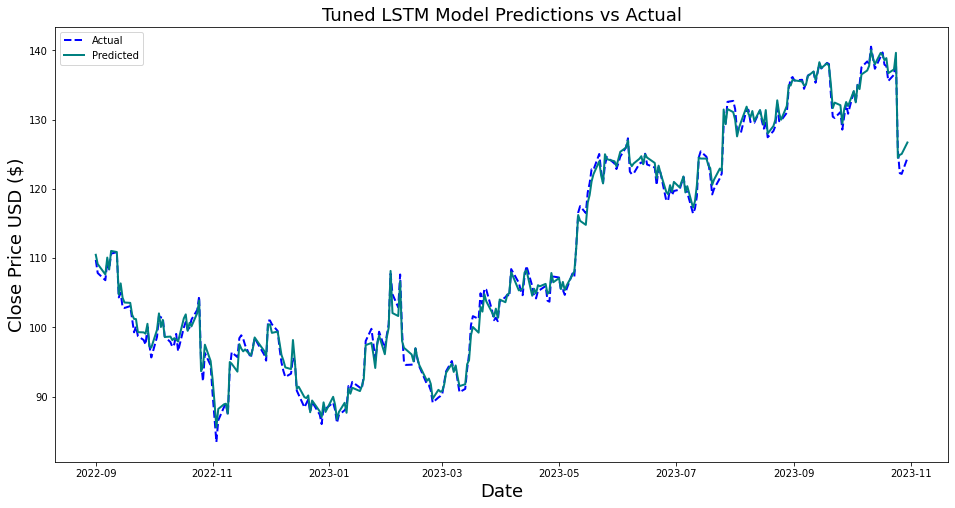

In [30]:
# Plot the actual values vs the predicted values for Best LSTM model
plt.figure(figsize=(16,8))
plt.title('Tuned LSTM Model Predictions vs Actual', fontsize=18)
plt.plot(df1[-len(y_test_inv):].index, y_test_inv, linewidth=2, color='blue', label='Actual', linestyle='--')
plt.plot(df1[-len(y_test_inv):].index, pred_best_lstm_inv, linewidth=2, color='teal', label='Predicted', linestyle='solid')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()

In [31]:
# XGBRegressor model with hyperparameter tuning
# Define the parameter grid
param_grid = {'n_estimators': [100, 200, 300],
                'max_depth': [3, 4, 5, 10, 15, 20],
                'learning_rate': [0.01, 0.05, 0.1],
                'colsample_bytree': [0.3, 0.5, 0.7],
                'gamma': [0, 0.1, 0.2]}

# Grid search on XGBRegressor
grid = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)
print("Best estimator: ", grid_result.best_estimator_)

# Using the best estimator for XGBRegressor from the grid search
best_xgb_model = grid_result.best_estimator_

# Predicting the test data
pred_best_xgb = best_xgb_model.predict(X_test)

# Inverse transform the predictions
pred_best_xgb_inv = target_scaler.inverse_transform(pred_best_xgb.reshape(-1,1))

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best parameters:  {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
Best score:  0.9729029346752484
Best estimator:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [32]:
# Calculate Evaluation Metrics for XGBRegressor model
best_xgb_mse = mean_squared_error(y_test_inv, pred_best_xgb_inv)
best_xgb_rmse = np.sqrt(best_xgb_mse)
best_xgb_mae = mean_absolute_error(y_test_inv, pred_best_xgb_inv)
best_xgb_r2 = r2_score(y_test_inv, pred_best_xgb_inv)

print("Tuned XGBRegressor Model Evaluation Metrics")
print("-------------------------------------------")
print("MSE: {:.4f}".format(best_xgb_mse))
print("RMSE: {:.4f}".format(best_xgb_rmse))
print("MAE: {:.4f}".format(best_xgb_mae))
print("R2 Score: {:.4f}".format(best_xgb_r2))

Tuned XGBRegressor Model Evaluation Metrics
-------------------------------------------
MSE: 1.0999
RMSE: 1.0487
MAE: 0.7875
R2 Score: 0.9958


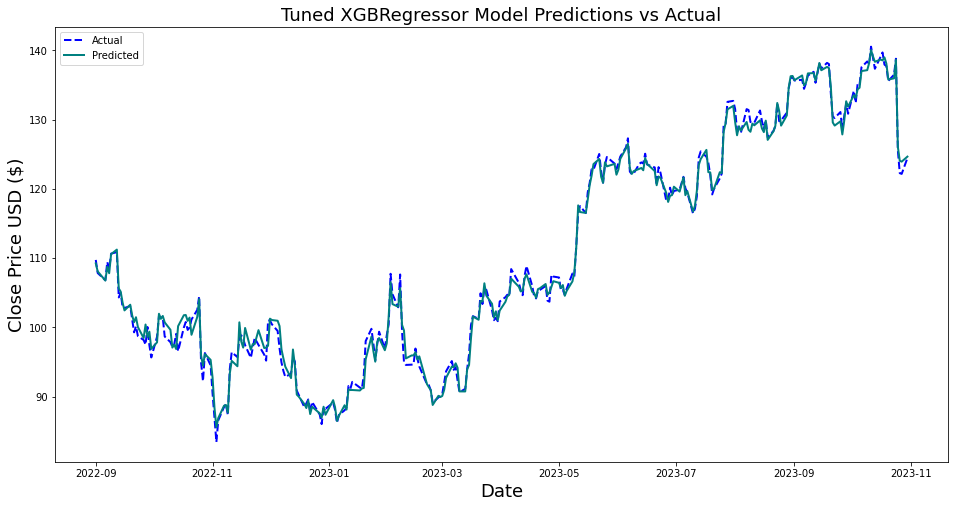

In [33]:
# Plot the actual values vs the predicted values for Best XGBRegressor model
plt.figure(figsize=(16,8))
plt.title('Tuned XGBRegressor Model Predictions vs Actual', fontsize=18)
plt.plot(df1[-len(y_test_inv):].index, y_test_inv, linewidth=2, color='blue', label='Actual', linestyle='--')
plt.plot(df1[-len(y_test_inv):].index, pred_best_xgb_inv, linewidth=2, color='teal', label='Predicted', linestyle='solid')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()

In [34]:
# Create a stacked model
stacked_tuned_pred = np.column_stack((pred_best_lstm, pred_best_xgb))

# Train final regressor based on stacked predictions
final_tuned_regressor = LinearRegression().fit(stacked_tuned_pred, y_test)

# Make predictions
final_tuned_pred = final_tuned_regressor.predict(stacked_tuned_pred)

# Inverse transform the predictions
final_tuned_pred_inv = target_scaler.inverse_transform(final_tuned_pred.reshape(-1,1))

In [35]:
# Calculate Evaluation Metrics for Stacked model
final2_mse = mean_squared_error(y_test_inv, final_tuned_pred_inv)
final2_rmse = np.sqrt(final2_mse)
final2_mae = mean_absolute_error(y_test_inv, final_tuned_pred_inv)
final2_r2 = r2_score(y_test_inv, final_tuned_pred_inv)

print("Tuned LSTM-XGBoost Stacked Model Evaluation Metrics")
print("---------------------------------------------------")
print("MSE: {:.4f}".format(final2_mse))
print("RMSE: {:.4f}".format(final2_rmse))
print("MAE: {:.4f}".format(final2_mae))
print("R2 Score: {:.4f}".format(final2_r2))

Tuned LSTM-XGBoost Stacked Model Evaluation Metrics
---------------------------------------------------
MSE: 0.7424
RMSE: 0.8616
MAE: 0.6624
R2 Score: 0.9972


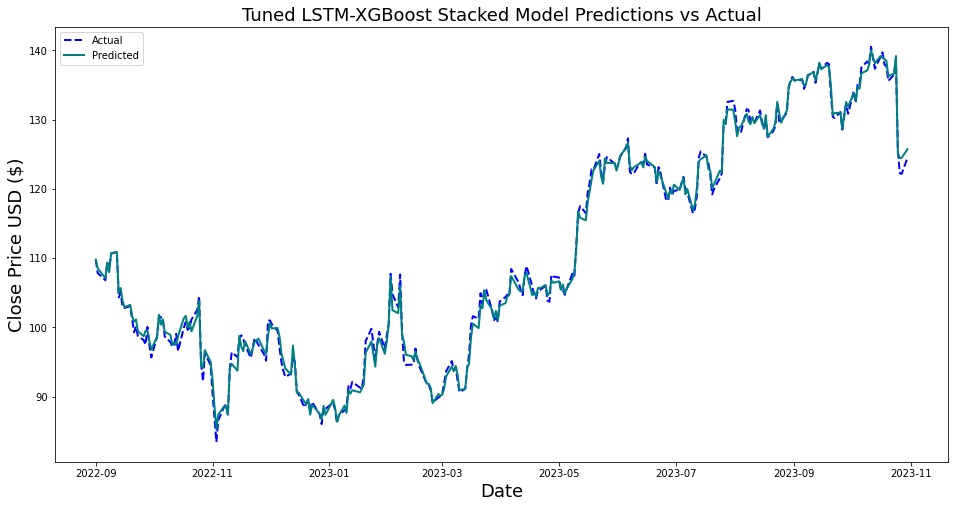

In [36]:
# Plot the actual values vs the predicted values for Best Stacked model
plt.figure(figsize=(16,8))
plt.title('Tuned LSTM-XGBoost Stacked Model Predictions vs Actual', fontsize=18)
plt.plot(df1[-len(y_test_inv):].index, y_test_inv, linewidth=2, color='blue', label='Actual', linestyle='--')
plt.plot(df1[-len(y_test_inv):].index, final_tuned_pred_inv, linewidth=2, color='teal', label='Predicted', linestyle='solid')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()

In [37]:
# Build a dataframe with actual and predicted prices for the best models
df_pred_1 = pd.DataFrame({'Date': df1.index[-len(y_test):], 'Actual': y_test_inv.flatten(),'Tuned LSTM': pred_best_lstm_inv.flatten(), 'Tuned XGBoost': pred_best_xgb_inv.flatten(), 'Tuned LSTM-XGBoost': final_tuned_pred_inv.flatten()})
df_pred_1

,Date,Actual,Tuned LSTM,Tuned XGBoost,Tuned LSTM-XGBoost
0,2022-09-01,109.739998,110.482971,109.237717,109.791962
1,2022-09-02,107.849998,109.150208,108.084297,108.533165
2,2022-09-06,106.809998,107.641823,106.756020,107.098305
3,2022-09-07,109.449997,110.080360,108.767097,109.357361
4,2022-09-08,108.379997,108.378021,107.817070,107.982162
...,...,...,...,...,...
287,2023-10-24,138.809998,139.666199,138.657166,139.207169
288,2023-10-25,125.610001,124.486153,126.089127,125.122643
289,2023-10-26,122.279999,124.920372,124.066223,124.466087
290,2023-10-27,122.169998,125.048767,123.941544,124.482506


In [38]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_best_lstm = []

# Predicting stock prices for the next 2 days
for _ in range(2):
    # Prepare the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predicting the next day stock price using the last feature data
    predicted_price = best_lstm_model.predict(last_features_lstm)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_best_lstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (Best LSTM Model):")
for i, price in enumerate(predicted_prices_best_lstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 26ms/step
Predicted Closing Prices for the Next 2 Days (Best LSTM Model):
Day 1:126.709
Day 2:123.797


In [39]:
last_features = X_scaled[-1:]

# Predict using the XGB model
predicted_prices_best_xgb = []

last_features_xgb = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_xgb = best_xgb_model.predict(last_features_xgb)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_xgb = predicted_price_xgb.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_xgb = target_scaler.inverse_transform(predicted_price_reshaped_xgb)[0][0]
    predicted_prices_best_xgb.append(inverse_transformed_price_xgb)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_xgb = np.array([
        last_features_xgb[0, 1], 
        last_features_xgb[0, 2], 
        predicted_price_reshaped_xgb[0, 0], 
        (predicted_price_reshaped_xgb[0, 0] - last_features_xgb[0, 3]) / last_features_xgb[0, 3],
        np.mean(np.append(last_features_xgb[0, 4:6], predicted_price_reshaped_xgb[0, 0])),
        np.mean(np.append(last_features_xgb[0, 5:], predicted_price_reshaped_xgb[0, 0])),
        np.std(np.append(last_features_xgb[0, 6:], predicted_price_reshaped_xgb[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_xgb = new_features_xgb

print("\nPredicted Closing Prices for the Next 2 Days (Best XGB Model):")
for i, price in enumerate(predicted_prices_best_xgb):
    print(f"Day {i+1}:" "{:.3f}".format(price))



Predicted Closing Prices for the Next 2 Days (Best XGB Model):
Day 1:124.667
Day 2:123.846


In [40]:
last_features = X_scaled[-1:]

# Predict using the Stacked LSTM-XGB model
predicted_prices_stacked = []

for day in range(2):
    # Reshape the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predict using LSTM & XGB models
    lstm_pred_for_stacking = best_lstm_model.predict(last_features_lstm).flatten()
    xgb_pred_for_stacking = best_xgb_model.predict(last_features).flatten()

    # Stacking LSTM and xgb predictions
    stacked_predictions = np.column_stack((lstm_pred_for_stacking, xgb_pred_for_stacking))
    
    # Predict using the final regressor
    predicted_stacked = final_tuned_regressor.predict(stacked_predictions)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_stacked = predicted_stacked.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_stacked = target_scaler.inverse_transform(predicted_price_reshaped_stacked)[0][0]
    predicted_prices_stacked.append(inverse_transformed_price_stacked)

    # For the next prediction, update the features with the newly predicted price.
    # We reuse the logic from LSTM to compute new features for simplicity.
    new_features_stacked = np.array([
        last_features[0, 1], 
        last_features[0, 2], 
        predicted_price_reshaped_stacked[0, 0], 
        (predicted_price_reshaped_stacked[0, 0] - last_features[0, 3]) / last_features[0, 3],
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped_stacked[0, 0])),
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped_stacked[0, 0])),
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped_stacked[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features_stacked

print("\nPredicted Closing Prices for the Next 2 Days (Best Stacked LSTM-XGB Model):")
for i, price in enumerate(predicted_prices_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step

Predicted Closing Prices for the Next 2 Days (Best Stacked LSTM-XGB Model):
Day 1:126.931
Day 2:124.735
